In [3]:
import csv
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt


In [4]:

# Function to read the CSV file and return the coordinates and frames
def read_csv(file_path):
    x_coords_obj1 = []
    y_coords_obj1 = []
    x_coords_obj2 = []
    y_coords_obj2 = []
    frames = []

    with open(file_path, mode="r") as file:
        reader = csv.reader(file)
        next(reader)  # Skip header

        for row in reader:
            frame = int(row[0])
            x1, y1 = row[1], row[2]
            x2, y2 = row[3], row[4]

            frames.append(frame)

            if x1 != 'None' and y1 != 'None':
                x_coords_obj1.append(float(x1))
                y_coords_obj1.append(float(y1))

            if x2 != 'None' and y2 != 'None':
                x_coords_obj2.append(float(x2))
                y_coords_obj2.append(float(y2))

    return frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2


In [5]:

# Function to calculate the distance from the circle
def calc_R(xc, yc, x, y):
    return np.sqrt((x - xc)**2 + (y - yc)**2)

# Function to optimize
def func_to_optimize(params, x, y):
    xc, yc = params
    Ri = calc_R(xc, yc, x, y)
    return Ri - Ri.mean()

# Function to perform least squares optimization and return the center and radius
def fit_circle(x_coords, y_coords):
    x_m = np.mean(x_coords)
    y_m = np.mean(y_coords)
    initial_guess = [x_m, y_m]
    result = least_squares(func_to_optimize, initial_guess, args=(x_coords, y_coords))
    xc, yc = result.x
    Ri = calc_R(xc, yc, x_coords, y_coords)
    R = Ri.mean()
    return (xc, yc), R

# Function to calculate the center of circular motion for both objects
def calculate_centers(x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2):
    center_obj1, radius_obj1 = fit_circle(x_coords_obj1, y_coords_obj1)
    center_obj2, radius_obj2 = fit_circle(x_coords_obj2, y_coords_obj2)
    return center_obj1, center_obj2, radius_obj1, radius_obj2


In [6]:

# Function to calculate angles for both objects
def calculate_angles(frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2, center_obj1, center_obj2):
    angles_obj1 = []
    angles_obj2 = []

    for x1, y1, x2, y2 in zip(x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2):
        # Calculate angle for object 1
        angle1 = np.arctan2(y1 - center_obj1[1], x1 - center_obj1[0])
        angles_obj1.append(angle1)

        # Calculate angle for object 2
        angle2 = np.arctan2(y2 - center_obj2[1], x2 - center_obj2[0])
        angles_obj2.append(angle2)

    return angles_obj1, angles_obj2

# Function to calculate velocities for both objects
def calculate_velocities(frames, angles_obj1, angles_obj2):
    np_angles_obj1 = np.array(angles_obj1[::6])
    np_angles_obj2 = np.array(angles_obj2[::6])
    np_frames = np.array(frames[::6])

    angle_v1 = []
    angle_v2 = []
    angle_forv1 = []
    angle_forv2 = []

    for i in range(len(np_frames) - 1):
        delta_t = np_frames[i + 1] - np_frames[i]
        delta_x1 = (np_angles_obj1[i + 1] - np_angles_obj1[i])
        delta_x2 = np_angles_obj2[i + 1] - np_angles_obj2[i]
        if delta_x1 > 2:
            delta_x1 -= 2 * np.pi
        if delta_x2 > 2:
            delta_x2 -= 2 * np.pi
        v1 = (delta_x1 / delta_t)
        v2 = delta_x2 / delta_t
        angle_v1.append(v1)
        angle_v2.append(v2)
        angle_forv1.append(np_angles_obj1[i])
        angle_forv2.append(np_angles_obj2[i])

    return np.array(angle_v1), np.array(angle_v2), np.array(angle_forv1), np.array(angle_forv2)


In [24]:
def plot_results(frames, angles_obj1, angles_obj2, angle_forv1, angle_v1, angle_forv2, angle_v2):
    minuites = [frame / 3600 for frame in frames]

    interval_size = np.pi / 8
    angle_bins = np.arange(-np.pi, np.pi, interval_size)
    avg_velocity1 = []
    avg_velocity2 = []

    for i in range(len(angle_bins) - 1):
        mask1 = (angle_forv1 >= angle_bins[i]) & (angle_forv1 < angle_bins[i + 1])
        if np.any(mask1):
            avg_velocity1.append(np.mean(angle_v1[mask1]))
        else:
            avg_velocity1.append(None)
        
        mask2 = (angle_forv2 >= angle_bins[i]) & (angle_forv2 < angle_bins[i + 1])
        if np.any(mask2):
            avg_velocity2.append(np.mean(angle_v2[mask2]))
        else:
            avg_velocity2.append(None)

    fig, axs = plt.subplots(4, 1, figsize=(6, 16))

    # Plot angles
    axs[0].plot(minuites, angles_obj1, label="Object 1 Angle (radians)", color="blue")
    axs[0].plot(minuites, angles_obj2, label="Object 2 Angle (radians)", color="green")
    axs[0].set_xlabel("Time (minutes)")
    axs[0].set_ylabel("Angle (radians)")
    axs[0].set_title("Angles of Tracked Objects Over Time")
    axs[0].legend()
    axs[0].grid(True)

    # Scatter plot of angular velocity with moving average for Object 1
    axs[1].scatter(angle_forv1, angle_v1, label="Object 1 Velocity")
    axs[1].plot((angle_bins[:-1] + angle_bins[1:]) / 2, avg_velocity1, color='red', label="Object 1 Moving Average (pi/8)", linestyle='-', marker='o')
    axs[1].set_xlabel("Angle (radians)")
    axs[1].set_ylabel("Angular Velocity")
    axs[1].set_title("Object 1 Velocity over Angle with Moving Average")
    axs[1].legend()
    axs[1].grid(True)

    # Scatter plot of angular velocity with moving average for Object 2
    axs[2].scatter(angle_forv2, angle_v2, label="Object 2 Velocity")
    axs[2].plot((angle_bins[:-1] + angle_bins[1:]) / 2, avg_velocity2, color='red', label="Object 2 Moving Average (pi/8)", linestyle='-', marker='o')
    axs[2].set_xlabel("Angle (radians)")
    axs[2].set_ylabel("Angular Velocity")
    axs[2].set_title("Object 2 Velocity over Angle with Moving Average")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

Calculated center for Object 1: (546.5799666825801, 427.46465919548416)
Calculated radius for Object 1: 305.65229436531
Calculated center for Object 2: (1291.9575602993916, 424.72517145944977)
Calculated radius for Object 2: 290.5101109895381


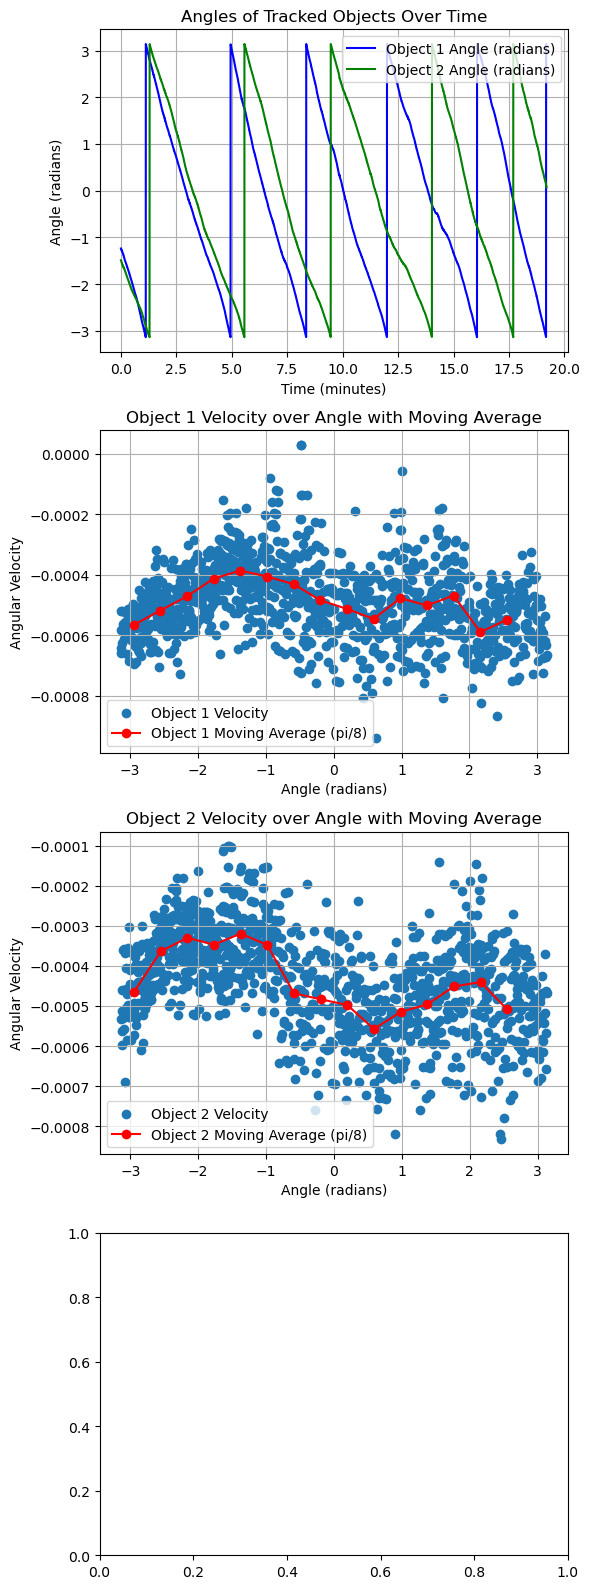

In [26]:

file_path = "object_tracking_coordinates.csv"

frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2 = read_csv(file_path)

# Calculate centers
center_obj1, center_obj2, radius_obj1, radius_obj2 = calculate_centers(x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2)
print(f"Calculated center for Object 1: {center_obj1}")
print(f"Calculated radius for Object 1: {radius_obj1}")
print(f"Calculated center for Object 2: {center_obj2}")
print(f"Calculated radius for Object 2: {radius_obj2}")
center_obj1 = (594,460)
center_obj2 = (1329,460)
# Calculate angles
angles_obj1, angles_obj2 = calculate_angles(frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2, center_obj1, center_obj2)

# Calculate velocities
angle_v1, angle_v2, angle_forv1, angle_forv2 = calculate_velocities(frames, angles_obj1, angles_obj2)

# Plot results
plot_results(frames, angles_obj1, angles_obj2, angle_forv1, angle_v1, angle_forv2, angle_v2)




In [ ]:
from scipy.optimize import curve_fit

# Sine function definition
def sine_function(x, A, k, phi, C):
    return A * np.sin(k * x + phi) + C

# Function to fit sine curve to phase-space data
def fit_sine_curve(angle_data, velocity_data):
    # Refined initial guess for [Amplitude, Frequency, Phase, Offset]
    amplitude_guess = np.ptp(velocity_data) / 2
    offset_guess = np.mean(velocity_data)
    frequency_guess = 2 * np.pi / (np.max(angle_data) - np.min(angle_data))
    phase_guess = 0
    initial_guess = [amplitude_guess, frequency_guess, phase_guess, offset_guess]
    
    # Fit the sine curve
    try:
        params, _ = curve_fit(
            sine_function, 
            angle_data, 
            velocity_data, 
            p0=initial_guess, 
            maxfev=10000,
            bounds=([0, 0, -np.pi, -np.inf], [np.inf, np.inf, np.pi, np.inf])
        )
    except RuntimeError as e:
        print(f"Error fitting sine curve: {e}")
        params = [0, 0, 0, 0]  # Return default parameters if fit fails
    
    return params

# Updated plot_results function to include sine fitting
def plot_results_with_fitting_to_moving_average(frames, angles_obj1, angles_obj2, angle_forv1, angle_v1, angle_forv2, angle_v2):
    minuites = [frame / 3600 for frame in frames]

    interval_size = np.pi / 8
    angle_bins = np.arange(-np.pi, np.pi, interval_size)
    avg_velocity1 = []
    avg_velocity2 = []
    avg_angle_bins = (angle_bins[:-1] + angle_bins[1:]) / 2

    for i in range(len(angle_bins) - 1):
        mask1 = (angle_forv1 >= angle_bins[i]) & (angle_forv1 < angle_bins[i + 1])
        if np.any(mask1):
            avg_velocity1.append(np.mean(angle_v1[mask1]))
        else:
            avg_velocity1.append(None)
        
        mask2 = (angle_forv2 >= angle_bins[i]) & (angle_forv2 < angle_bins[i + 1])
        if np.any(mask2):
            avg_velocity2.append(np.mean(angle_v2[mask2]))
        else:
            avg_velocity2.append(None)

    # Filter out None values from moving averages for fitting
    avg_velocity1 = np.array([v for v in avg_velocity1 if v is not None])
    avg_velocity2 = np.array([v for v in avg_velocity2 if v is not None])
    avg_angle_bins_cleaned1 = np.array([a for a, v in zip(avg_angle_bins, avg_velocity1) if v is not None])
    avg_angle_bins_cleaned2 = np.array([a for a, v in zip(avg_angle_bins, avg_velocity2) if v is not None])

    # Fit sine curves to the moving average
    params_obj1 = fit_sine_curve(avg_angle_bins_cleaned1, avg_velocity1)
    params_obj2 = fit_sine_curve(avg_angle_bins_cleaned2, avg_velocity2)
    print(f"Sine fit parameters for Object 1 (fitted to moving average): {params_obj1}")
    print(f"Sine fit parameters for Object 2 (fitted to moving average): {params_obj2}")

    # Generate sine fit data
    sine_fit_obj1 = sine_function(avg_angle_bins_cleaned1, *params_obj1)
    sine_fit_obj2 = sine_function(avg_angle_bins_cleaned2, *params_obj2)

    fig, axs = plt.subplots(4, 1, figsize=(8, 20))

    # Plot angles over time
    axs[0].plot(minuites, angles_obj1, label="Object 1 Angle (radians)", color="blue")
    axs[0].plot(minuites, angles_obj2, label="Object 2 Angle (radians)", color="green")
    axs[0].set_xlabel("Time (minutes)")
    axs[0].set_ylabel("Angle (radians)")
    axs[0].set_title("Angles of Tracked Objects Over Time")
    axs[0].legend()
    axs[0].grid(True)

    # Scatter plot of angular velocity with sine fit and moving average for Object 1
    axs[1].scatter(angle_forv1, angle_v1, label="Object 1 Velocity (Raw Data)", alpha=0.5)
    axs[1].plot(avg_angle_bins, avg_velocity1, color='purple', label="Moving Average (pi/8)", linestyle='--', marker='o')
    axs[1].plot(avg_angle_bins_cleaned1, sine_fit_obj1, color='red', label="Sine Fit (to Moving Average)", linestyle='-')
    axs[1].set_xlabel("Angle (radians)")
    axs[1].set_ylabel("Angular Velocity")
    axs[1].set_title("Object 1 Velocity over Angle with Sine Fit (to Moving Average)")
    axs[1].legend()
    axs[1].grid(True)

    # Scatter plot of angular velocity with sine fit and moving average for Object 2
    axs[2].scatter(angle_forv2, angle_v2, label="Object 2 Velocity (Raw Data)", alpha=0.5)
    axs[2].plot(avg_angle_bins, avg_velocity2, color='purple', label="Moving Average (pi/8)", linestyle='--', marker='o')
    axs[2].plot(avg_angle_bins_cleaned2, sine_fit_obj2, color='red', label="Sine Fit (to Moving Average)", linestyle='-')
    axs[2].set_xlabel("Angle (radians)")
    axs[2].set_ylabel("Angular Velocity")
    axs[2].set_title("Object 2 Velocity over Angle with Sine Fit (to Moving Average)")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
